In [13]:
import keras

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import sys

# 数据导入&探索
## 数据导入

In [10]:
df = pd.read_csv("/Users/renzhiqiang/Workspace/data/iops-kpi/train.csv")
print(df['KPI ID'].unique())
kpi=df[df["KPI ID"]=='769894baefea4e9e']
kpi['timestamp'] = pd.to_datetime(kpi['timestamp'], unit="s")
kpi.index = kpi['timestamp']
kpi.head()

['02e99bd4f6cfb33f' '9bd90500bfd11edb' 'da403e4e3f87c9e0'
 'a5bf5d65261d859a' '18fbb1d5a5dc099d' '09513ae3e75778a3'
 'c58bfcbacb2822d1' '1c35dbf57f55f5e4' '046ec29ddf80d62e'
 '07927a9a18fa19ae' '54e8a140f6237526' 'b3b2e6d1a791d63a'
 '8a20c229e9860d0c' '769894baefea4e9e' '76f4550c43334374'
 'e0770391decc44ce' '8c892e5525f3e491' '40e25005ff8992bd'
 'cff6d3c01e6a6bfa' '71595dd7171f4540' '7c189dd36f048a6c'
 'a40b1df87e3f1c87' '8bef9af9a922e0b3' 'affb01ca2b4f0b45'
 '9ee5879409dccef9' '88cf3a776ba00e7c']


/var/folders/97/nf61081d1l7135m5v32qhhxc0000gn/T/ipykernel_7146/562255532.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['timestamp'] = pd.to_datetime(kpi['timestamp'], unit="s")


,timestamp,value,label,KPI ID
timestamp,,,,
2016-10-27 16:00:00,2016-10-27 16:00:00,0.103812,0,769894baefea4e9e
2016-10-27 16:05:00,2016-10-27 16:05:00,0.101444,0,769894baefea4e9e
2016-10-27 16:10:00,2016-10-27 16:10:00,0.104126,0,769894baefea4e9e
2016-10-27 16:15:00,2016-10-27 16:15:00,0.094780,0,769894baefea4e9e
2016-10-27 16:20:00,2016-10-27 16:20:00,0.093140,0,769894baefea4e9e


## 数据展示

Text(0, 0.5, 'value')

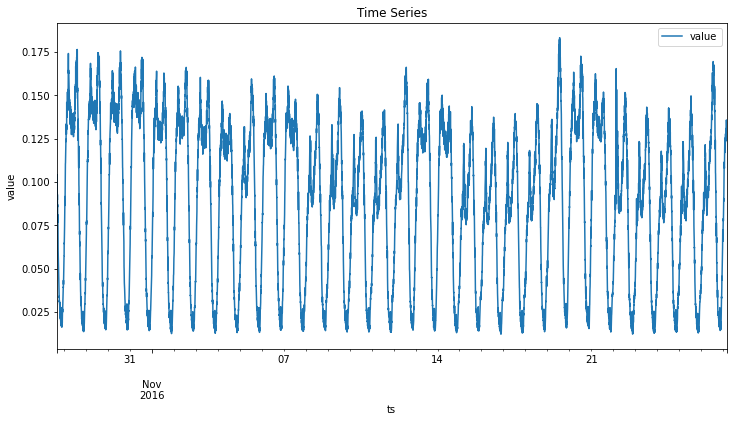

In [15]:
df = kpi
df.plot(x="timestamp", y="value", figsize=(12, 6))
plt.title("Time Series")
plt.xlabel("ts")
plt.ylabel("value")

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='value', ylabel='Density'>

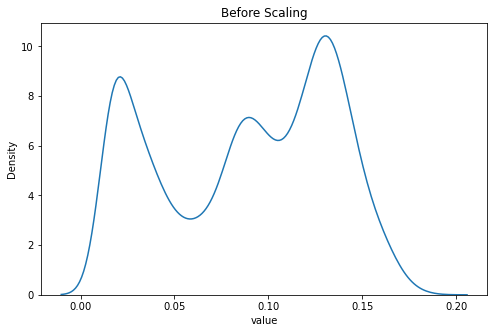

In [17]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title("Before Scaling")
sns.kdeplot(df['value'], ax=ax1)

In [18]:
df["value"].describe()

count    8784.000000
mean        0.088519
std         0.046166
min         0.012249
25%         0.041139
50%         0.094716
75%         0.128819
max         0.183211
Name: value, dtype: float64

# 数据预处理
## 归一化

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = scaler.fit_transform(df['value'].values.reshape(-1, 1))

In [23]:
df.head()

,timestamp,value,label,KPI ID,scaled_value
timestamp,,,,,
2016-10-27 16:00:00,2016-10-27 16:00:00,0.103812,0,769894baefea4e9e,0.535576
2016-10-27 16:05:00,2016-10-27 16:05:00,0.101444,0,769894baefea4e9e,0.521725
2016-10-27 16:10:00,2016-10-27 16:10:00,0.104126,0,769894baefea4e9e,0.537409
2016-10-27 16:15:00,2016-10-27 16:15:00,0.094780,0,769894baefea4e9e,0.482746
2016-10-27 16:20:00,2016-10-27 16:20:00,0.093140,0,769894baefea4e9e,0.473150


# 构建模型

In [30]:
time_steps=48
metric = 'mean_absolute_error'

model=keras.models.Sequential()
model.add(keras.layers.LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 48, 32)            4352      
                                                                 
 dense_1 (Dense)             (None, 48, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
sequence = np.array(df['scaled_value'])
n_samples = len(sequence)
trim = n_samples % time_steps

subsequences = int(n_samples/time_steps)
sequence_trimmed = sequence[:n_samples - trim]
sequence_trimmed = sequence_trimmed.reshape(subsequences, time_steps, 1)
print(sequence_trimmed.shape)

(183, 48, 1)


In [35]:
training_dataset = sequence_trimmed

batch_size=32
epochs=10

model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size, epochs=epochs, verbose=1,
         validation_data=(training_dataset, training_dataset))

Epoch 1/10
4/6 [===================>..........] - ETA: 0s - loss: 0.0947 - mean_absolute_error: 0.0947

2022-02-24 19:11:44.995620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-24 19:11:45.042402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 128ms/step - loss: 0.0919 - mean_absolute_error: 0.0919 - val_loss: 0.0865 - val_mean_absolute_error: 0.0865
Epoch 2/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0843 - mean_absolute_error: 0.0843 - val_loss: 0.0808 - val_mean_absolute_error: 0.0808
Epoch 3/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0781 - mean_absolute_error: 0.0781 - val_loss: 0.0758 - val_mean_absolute_error: 0.0758
Epoch 4/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0726 - mean_absolute_error: 0.0726 - val_loss: 0.0710 - val_mean_absolute_error: 0.0710
Epoch 5/10
6/6 [==============================] - 0s 31ms/step - loss: 0.0677 - mean_absolute_error: 0.0677 - val_loss: 0.0652 - val_mean_absolute_error: 0.0652
Epoch 6/10
6/6 [==============================] - 0s 30ms/step - loss: 0.0638 - mean_absolute_error: 0.0638 - val_loss: 0.0614 - val_mean_absolute_error: 0.0614
Epoch 7/10
6/6 [============================

In [38]:
pred = model.predict(training_dataset)
print(training_dataset.shape, pred.shape)

(183, 48, 1) (183, 48, 1)
